In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
import numpy as np
import plotly as py
import plotly.graph_objs as go
import datetime

py.offline.init_notebook_mode(connected = True)


In [3]:
markersDataFileName = "2019-03-06-15-54-15-788_markers_exp1.txt"
phoneDataFileName = "2019-03-06-15-54-15-854.txt"

In [26]:
markersData = []
phoneData = []

with open(phoneDataFileName, 'r') as file:
    itemHeaders = ["timeStamp", "logIndex", "keyboardID", "eventID", "x", "y"]
    for line in file:
        logEntry = line.split()
        if len(logEntry) == len(itemHeaders):
            phoneDatum = {itemName: data for itemName, data in zip(itemHeaders, logEntry)}
            phoneDatum["timeStamp"] = datetime.datetime.strptime(phoneDatum["timeStamp"], "%Y-%m-%d-%H-%M-%S-%f")
            phoneDatum["eventID"] = int(phoneDatum["eventID"])
            phoneDatum["logIndex"] = int(phoneDatum["logIndex"])
            phoneDatum["x"] = float(phoneDatum["x"])
            phoneDatum["y"] = float(phoneDatum["y"])          
            phoneData.append(phoneDatum)
        
with open(markersDataFileName, 'r') as file:
    itemHeaders = ["timeStamp", "logIndex", "markerID", "x", "y", "z"]
    for line in file:
        if logEntry != "":
            logEntry = line.split()
            if len(logEntry) == len(itemHeaders):
                timeStamp = datetime.datetime.strptime(logEntry[0], "%Y-%m-%d-%H-%M-%S-%f")
                if timeStamp >= phoneData[0]['timeStamp']:
                    markersDatum = {itemName: data for itemName, data in zip(itemHeaders, logEntry)}
                    markersDatum["timeStamp"] = timeStamp
                    markersDatum["markerID"] = int(markersDatum["markerID"])
                    markersDatum["logIndex"] = int(markersDatum["logIndex"])
                    markersDatum["x"] = float(markersDatum["x"])
                    markersDatum["y"] = float(markersDatum["y"])
                    markersDatum['z'] = float(markersDatum['z'])
                    markersData.append(markersDatum)
        

In [5]:
markersData.sort(key = lambda data: data["markerID"])

markersDataDictByID = collections.defaultdict(list)

for markersDatum in markersData:
    markersDataDictByID[markersDatum['markerID']].append(markersDatum)

In [6]:
plotData = collections.defaultdict(list)
for data in markersData:
    if data['timeStamp'] >= phoneData[0]['timeStamp'] and data['timeStamp'] <= phoneData[-1]['timeStamp']:
        plotData[data["markerID"]].append([float(data['x']), float(data['y']), float(data['z'])])

traces = []
for markerID, trajectory in plotData.items():
    trajectory = np.array(trajectory)
    trace = go.Scatter3d(
        x=trajectory[:,0],
        y=trajectory[:,1],
        z=trajectory[:,2],
        mode='lines',
        name = markerID
    )
    traces.append(trace)
    
fig = go.Figure(data = traces)



In [35]:
py.offline.plot(fig, filename = "all trajectory")

C:\Users\Dave Lei\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\offline\offline.py:621: UserWarning:

Your filename `all trajectory` didn't end with .html. Adding .html to the end of your file.



'file://C:\\Users\\Dave Lei\\Part IIB project\\Data logging\\all trajectory.html'

In [7]:
leftThumbIDs = [63195]
rightThumbIDs = [63217, 63744]
leftWristID = [63537]
rightWristID = [63181]



In [66]:
relevantIDs = leftThumbIDs + rightThumbIDs + leftWristID + rightWristID
traces = []
for markerID in relevantIDs:
    trajectory = np.array(plotData[markerID])
    trace = go.Scatter3d(
        x=trajectory[:,0],
        y=trajectory[:,1],
        z=trajectory[:,2],
        mode='lines',
        name = markerID
    )
    traces.append(trace)
    
fig = go.Figure(data = traces)
py.offline.plot(fig, filename = "wrists-and-thumbs")

'file://C:\\Users\\Dave Lei\\Part IIB project\\Data logging\\wrists-and-thumbs.html'

In [8]:
leftThumbTrajectory = []
rightThumbTrajectory = []
for markerID in leftThumbIDs:
    leftThumbTrajectory.extend(markersDataDictByID[markerID])
    
for markerID in rightThumbIDs:
    rightThumbTrajectory.extend(markersDataDictByID[markerID])

leftThumbTrajectory.sort(key = lambda datum: datum['logIndex'])
rightThumbTrajectory.sort(key = lambda datum: datum['logIndex'])

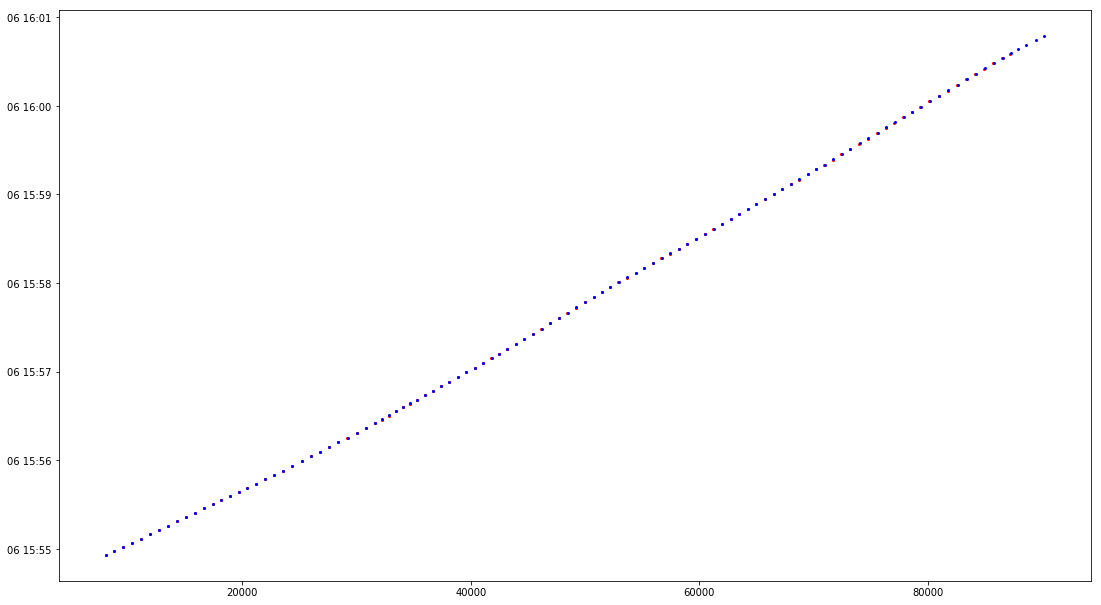

In [9]:
plt.plot([data['logIndex'] for data in leftThumbTrajectory][::50],[data['timeStamp'] for data in leftThumbTrajectory][::50],'ro', markerSize = 2)
plt.plot([data['logIndex'] for data in rightThumbTrajectory][::50],[data['timeStamp'] for data in rightThumbTrajectory][::50],'bo', markerSize = 2)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [22]:
def calculateSpeed(datum1, datum2):
    delta_t = datum2['timeStamp'] - datum1['timeStamp']
    velocity_x = datum2['x'] - datum1['x']
    velocity_y = datum2['y'] - datum1['y']
    velocity_z = datum2['z'] - datum1['z']
    
    return np.sqrt(velocity_x **2 + velocity_y **2 + velocity_z ** 2)/delta_t.total_seconds()

leftThumbSpeed = [calculateSpeed(leftThumbTrajectory[ind - 1], leftThumbTrajectory[ind + 1]) for ind in range(1, len(leftThumbTrajectory) - 1)]
leftThumbTimeStamp = [leftThumbTrajectory[ind]['timeStamp'] for ind in range(1, len(leftThumbTrajectory) - 1)]

rightThumbSpeed = [calculateSpeed(rightThumbTrajectory[ind - 1], rightThumbTrajectory[ind + 1]) for ind in range(1, len(rightThumbTrajectory) - 1)]
rightThumbTimeStamp = [rightThumbTrajectory[ind]['timeStamp'] for ind in range(1, len(rightThumbTrajectory) - 1)]


In [44]:
leftSpeedTrace = go.Scatter(
    x = leftThumbTimeStamp,
    y = leftThumbSpeed,
    mode = 'lines',
    name = 'leftSpeed'
)

rightSpeedTrace = go.Scatter(
    x = rightThumbTimeStamp,
    y = rightThumbSpeed,
    mode = 'lines',
    name = 'rightSpeed'
)

pressTrace = go.Scatter(
    x = [datum['timeStamp'] for datum in phoneData if datum["eventID"] in {0, 5}],
    y = [0 for datum in phoneData if datum["eventID"] in {0, 5}],
    mode = 'markers',
    name = 'press',
    marker = dict(
        size = 5,
        color = 'rgba(152, 0, 0, .8)'
        )
)

releaseTrace = go.Scatter(
    x = [datum['timeStamp'] for datum in phoneData if datum["eventID"] in {1, 6}],
    y = [0 for datum in phoneData if datum["eventID"] in {1, 6}],
    mode = 'markers',
    name = 'release',
    marker = dict(
        size = 5,
        color = 'rgba(0, 152, 0, .8)'
        )
)

data = [leftSpeedTrace, rightSpeedTrace, pressTrace, releaseTrace]

py.offline.iplot(data, filename='thumbSpeed')

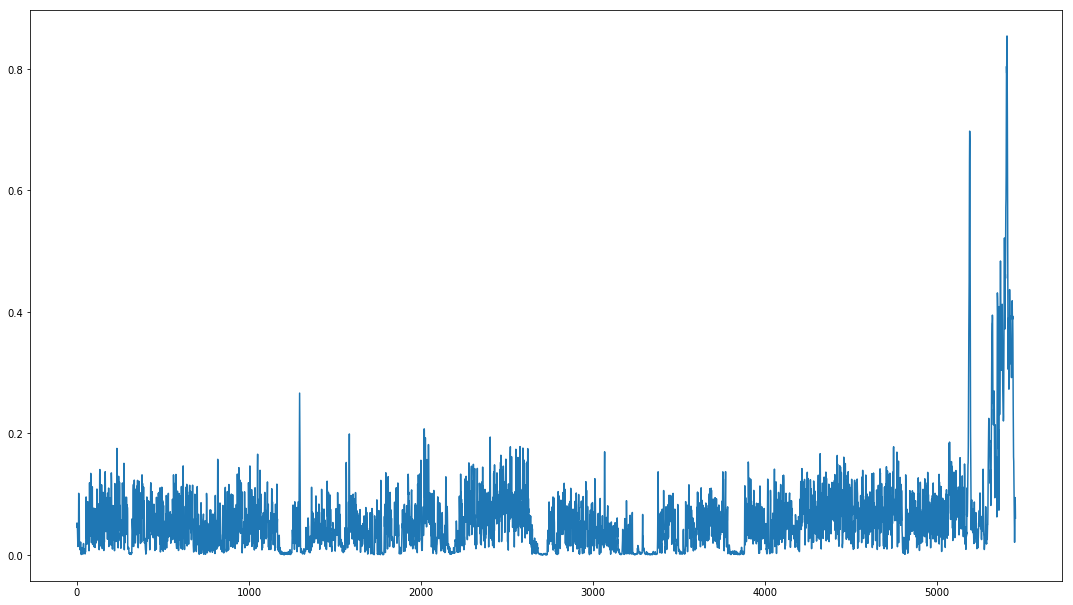

In [19]:
plt.plot(rightThumbSpeed)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

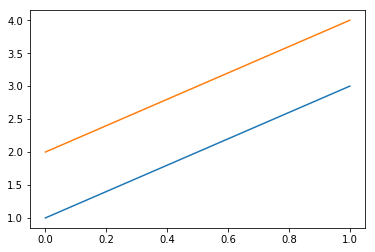